<a href="https://colab.research.google.com/github/sumanyurosha/tensorflow-specialization/blob/master/Practice/Practicing_on_Sarcasm_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Downloading the Sarcasm Dataset**

In [23]:

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json

--2020-10-20 13:55:49--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.04s   

2020-10-20 13:55:50 (149 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [24]:
import json

with open("/tmp/sarcasm.json") as f:
    datastore = json.load(f)

# **2. Data Preprocessing**

In [25]:
headlines = []
urls = []
labels = []

for item in datastore:
    headlines.append(item["headline"])
    urls.append(item["article_link"])
    labels.append(item["is_sarcastic"])


print("Size of dataset: {}".format(len(headlines)))

Size of dataset: 26709


In [26]:
headlines[:5]

["former versace store clerk sues over secret 'black code' for minority shoppers",
 "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
 "mom starting to fear son's web series closest thing she will have to grandchild",
 'boehner just wants wife to listen, not come up with alternative debt-reduction ideas',
 'j.k. rowling wishes snape happy birthday in the most magical way']

In [27]:
labels[:5]

[0, 0, 1, 1, 0]

In [32]:
oov_token = "<OOV>"
training_size = 20000
vocab_size = 10000
embedding_dim = 32
trunc_type = "post"
pad_type = "post"

In [33]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(headlines)

sequences = tokenizer.texts_to_sequences(headlines)
padded_sequences = pad_sequences(sequences, padding=pad_type, truncating=trunc_type)

max_len = len(padded_sequences[0])
print(max_len)

print("Headline : {}".format(headlines[0]))
print("Tokenized Sequence : {}".format(sequences[0]))
print("Padded Sequence : {}".format(padded_sequences[0]))

40
Headline : former versace store clerk sues over secret 'black code' for minority shoppers
Tokenized Sequence : [308, 1, 679, 3337, 2298, 48, 382, 2576, 1, 6, 2577, 8434]
Padded Sequence : [ 308    1  679 3337 2298   48  382 2576    1    6 2577 8434    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [34]:
train_padded = np.array(padded_sequences[:training_size])
valid_padded = np.array(padded_sequences[training_size:])

train_labels = np.array(labels[:training_size])
valid_labels = np.array(labels[training_size:])

print(len(train_padded))
print(len(valid_padded))

20000
6709


In [35]:
import matplotlib.pyplot as plt

def plot_graph(history, string):
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.plot(history.history[string])
    plt.plot(history.history["val_" + string])
    plt.legend([string, "val_" + string])
    plt.show()

# **Model with Multiple LSTM Layers**

In [39]:
model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_len),
    keras.layers.Dropout(0.3),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.LSTM(32),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation="sigmoid")
])

model.summary()

model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

history = model.fit(train_padded, train_labels, epochs=20, 
                    validation_data=(valid_padded, valid_labels), verbose=1)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 40, 32)            320000    
_________________________________________________________________
dropout (Dropout)            (None, 40, 32)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 40, 64)            24832     
_________________________________________________________________
lstm_13 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 357,281
Trainable params: 357,281
Non-trainable params: 0
_______________________________________________

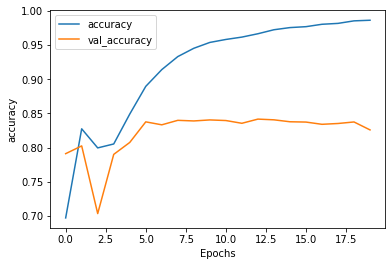

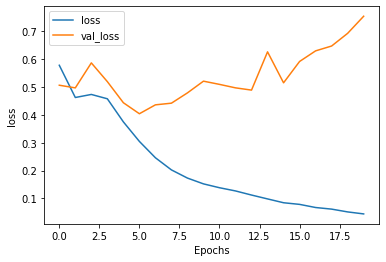

In [40]:
plot_graph(history, "accuracy")
plot_graph(history, "loss")

In [44]:
bidirectional_model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_len),
    keras.layers.Dropout(0.3),
    keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.LSTM(16)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation="sigmoid"),
])

bidirectional_model.summary()

bidirectional_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = bidirectional_model.fit(train_padded, train_labels, epochs=20, 
          validation_data=(valid_padded, valid_labels), verbose=1)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 40, 32)            320000    
_________________________________________________________________
dropout_6 (Dropout)          (None, 40, 32)            0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 40, 64)            16640     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 32)                10368     
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 33        
Total params: 347,041
Trainable params: 347,041
Non-trainable params: 0
_______________________________________________

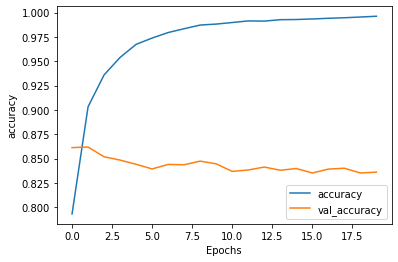

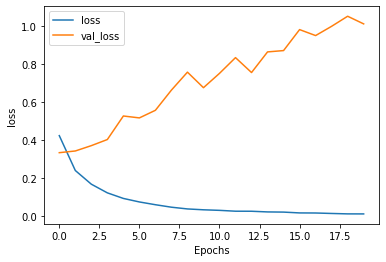

In [46]:
plot_graph(history, "accuracy")
plot_graph(history, "loss")